# Counterpart Take Home Assignment 
## Exploratory Data Analysis and Data Cleaning

* Data Preparation for Dashboard Tracking Hit Rate (Policy Count / Quote Count)

### Table of Contents:
* [Importing Data and Packages](#1)
* [Initial Data Quality Checks](#2)
* [Merging Tables](#3)
* [Identifying Any Missing Dates in Policy and Quote Dates](#4)
* [Cases Where Policy Date Exceeds 30 days for Quote Date](#5)
* [Linear Regression for Future Estimates](#6)
* [Naive Walk Forecast](#7)

### Importing Data and Packages <a id="1"></a> 

In [471]:
# Importing Packages
import pandas as pd 
import numpy as np 
import datetime 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from copy import deepcopy

In [472]:
# Importing Data
policy = pd.read_csv("policies.csv")
quotes = pd.read_csv("quotes.csv")
submissions = pd.read_csv("submissions.csv")

# Naming DataFrames for Reference 
policy.name = "Policy"
quotes.name = "Quotes"
submissions.name = "Submissions"

#### Data Quality Check <a id="2"></a>

In [473]:
# Data Quality Checks 

# Check for unique rows in a column and missing values 
def dq_check_col(df, col1):
    # Identifying Table Name 
    print(df.name, "Table >")
    # Identifying if column values are unique 
    print(col1, "Is Unique:", df[col1].is_unique)
    # Identifying any null values
    print(col1, "Is Null:", df[col1].isnull().any(), "\n" )
    
    # Flag when not unique or not duplicated 
    if df[col1].is_unique == False:
        raise Exception(df.name, col1, "Not Unique Column! \n")
    # Raising Exception when column is null 
    if df[col1].isnull().any() == True:
        raise Exception(df.name, col1, "Contains Missing Values! \n")

In [474]:
# Ensuring that Primary and Foreign Keys are not duplicated and not missing > This would be built into a data pipeline with automated checks (Airflow)
try:
    # Check Unique Rows for Quotes Table 
    dq_check_col(quotes, "Application ID")
    dq_check_col(quotes, "Quote ID")

    # Check Unique Rows for Policy Table 
    dq_check_col(policy, "Policy ID")
    dq_check_col(policy, "Quote ID")

    # Check Unique Rows for Submissions Table 
    dq_check_col(submissions, "Application ID")
    
    # Basic Data Quality Check Success
    print("Meets Primary Key Data Check!")
except:
    print("Check Exception Raised")

Quotes Table >
Application ID Is Unique: True
Application ID Is Null: False 

Quotes Table >
Quote ID Is Unique: True
Quote ID Is Null: False 

Policy Table >
Policy ID Is Unique: True
Policy ID Is Null: False 

Policy Table >
Quote ID Is Unique: True
Quote ID Is Null: False 

Submissions Table >
Application ID Is Unique: True
Application ID Is Null: False 

Meets Primary Key Data Check!


#### Converting Dates into Datetimes

In [475]:
policy['Policy Created At Date'] = pd.to_datetime(policy['Policy Created At Date'])
quotes['Quoted Date'] = pd.to_datetime(quotes['Quoted Date Date'])

#### Checking for Missing States and Industries 

In [476]:
# Number of Missing States
print("Number of Missing States", submissions['State'].isnull().sum())

# Number of Missing Industries
print("Number of Missing Industries", submissions['Industry'].isnull().sum())

Number of Missing States 0
Number of Missing Industries 85


In [477]:
# Filling in Missing Industry with Miscellaneous Services // If that is the reason.. if it was just not filled then it should be left blank
submissions['Industry'] = submissions['Industry'].fillna("Miscellaneous Services")

#### Joining Tables <a id="3"></a>

In [478]:
# Joining quotes into submissions table based on application id
df = submissions.merge(quotes, left_on="Application ID", right_on="Application ID", how="left")

# Joining policy into the base table based on quote id 
df = df.merge(policy, left_on="Quote ID", right_on="Quote ID", how="left")

# Cleaning up columns
df = df[['Application ID', 'State', 'Industry', 'Quote ID','Quoted Date', 'Policy ID', 'Policy Created At Date']]

# Defining Name for the DataFrame
df.name = "Joined Table"

In [479]:
df.head()

,Application ID,State,Industry,Quote ID,Quoted Date,Policy ID,Policy Created At Date
0,0001b80c-8a10-4943-8f5c-482a9909409c,Maine,Equipment & Vehicle Repair,0001b80c-8a10-4943-8f5c-482a9909409c,2022-12-05,NaN,NaT
1,000208ef-a4e1-42e6-b85c-2b384add52c1,Maine,Department & Wholesale Stores,000208ef-a4e1-42e6-b85c-2b384add52c1,2022-12-08,NaN,NaT
2,000811f7-0412-4d09-a429-23748bf5ffc9,Maine,Real Estate,000811f7-0412-4d09-a429-23748bf5ffc9,2022-11-17,NaN,NaT
3,001165e3-4d46-4497-8525-2f69b74288cf,Maine,Nonprofit & Member Organizations,NaN,NaT,NaN,NaT
4,00252e54-f499-45fa-a054-7bead2c13d2c,Maine,Performing Arts & Sports,NaN,NaT,NaN,NaT


#### Check if Any Quotes or Policies Weren't Joined

In [480]:
# Function to check if all primary and second keys were pulled in
def num_pk(final_df, ind_df, col1):
    if final_df[col1].nunique() == ind_df[col1].nunique():
        print("All", col1, "pulled in! \n")
    else:
        print(final_df.name, "has",final_df[col1].nunique(), col1, "rows")
        print(ind_df.name, "has",ind_df[col1].nunique(), col1, "rows")
        print(ind_df[col1].nunique() - final_df[col1].nunique(), col1, "was not pulled in! \n")

In [481]:
# Check if all Quote IDs were pulled in
num_pk(df, quotes, "Quote ID")

# Check if all Policy IDs were pulled in 
num_pk(df, policy, "Policy ID")

Joined Table has 3136 Quote ID rows
Quotes has 3148 Quote ID rows
12 Quote ID was not pulled in! 

Joined Table has 407 Policy ID rows
Policy has 418 Policy ID rows
11 Policy ID was not pulled in! 



#### Identifying Any Missing Dates in Policy and Quote Dates <a id="4"></a>

<Axes: xlabel='Count', ylabel='Quoted Date'>

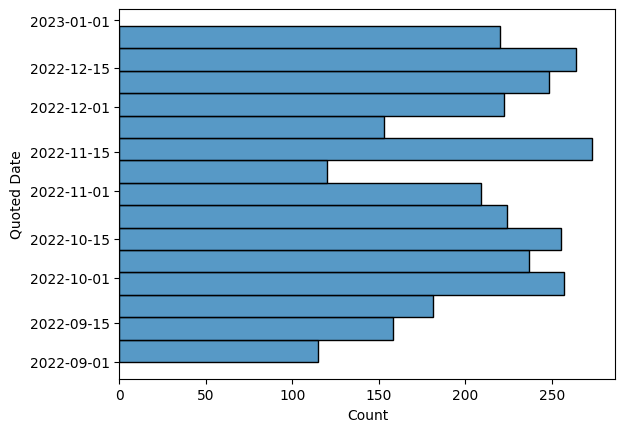

In [482]:
# Visualizing Quote Months and Distribution 
sns.histplot(data=df, y="Quoted Date")

<Axes: xlabel='Count', ylabel='Policy Created At Date'>

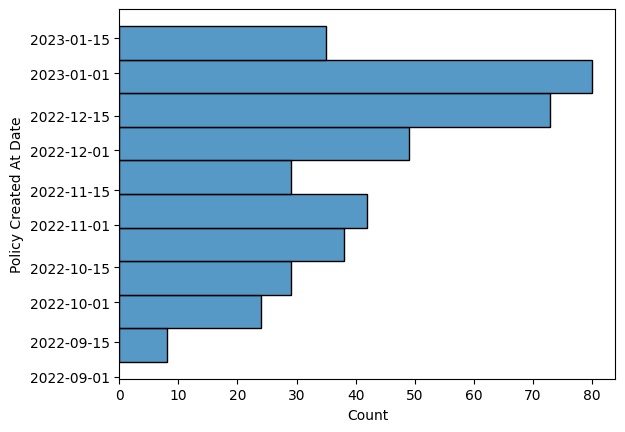

In [483]:
# Visualizing Quote Months and Distribution 
sns.histplot(data=df, y="Policy Created At Date")

#### Cases Where Policy Date Exceeds 30 days for Quote Date <a id="5"></a>

In [484]:
# Creating Column of Quoted Date + 30 Days 
df['Quoted Date Plus 30 Days'] = df['Quoted Date'] + datetime.timedelta(days=30)

# Creating column to identify dates were expired policy was created 
df['Expired Policy Created'] = df.apply(lambda x: 'Expired' if x['Quoted Date Plus 30 Days'] < x['Policy Created At Date'] else 'Not Expired', axis=1)

# Identifying Rows where Policy was created past the 30 days window 
expired_policy = df[df['Quoted Date Plus 30 Days'] < df['Policy Created At Date']]

print("The number of expired policies:",len(expired_policy))

# Show Expired Policies that were created
expired_policy.head()

The number of expired policies: 79


,Application ID,State,Industry,Quote ID,Quoted Date,Policy ID,Policy Created At Date,Quoted Date Plus 30 Days,Expired Policy Created
656,52a08196-0e01-47e7-abbe-a1d974814e4d,Maine,Restaurant & Food Services,52a08196-0e01-47e7-abbe-a1d974814e4d,2022-10-25,95eda22a-478f-4347-9c5d-3bf076e1cc52,2022-12-29,2022-11-24,Expired
892,6e260571-c215-4c14-91c0-22f45ba12271,Maine,Analytics & Business Intelligence,6e260571-c215-4c14-91c0-22f45ba12271,2022-09-09,9baf1ec9-dcd3-447a-83e0-52674bec6753,2022-11-11,2022-10-09,Expired
1020,81470a68-e6bc-4d81-834c-73cb63d2e9a8,Maine,Miscellaneous Wholesale,81470a68-e6bc-4d81-834c-73cb63d2e9a8,2022-10-27,ae70d84d-3c02-471c-918e-cfcd4d63c727,2022-12-07,2022-11-26,Expired
1421,af1c121f-b121-4a93-b0f4-d676abed2a1e,Maine,Transportation Equipment & Parts Manufacturing,af1c121f-b121-4a93-b0f4-d676abed2a1e,2022-10-11,ea4cbbd0-566c-430d-8d80-b672ddf2d1f1,2022-11-21,2022-11-10,Expired
2023,f50bde28-8b4d-44d7-8c91-d79076d31751,Maine,Technology Software,f50bde28-8b4d-44d7-8c91-d79076d31751,2022-12-20,41a15eac-2eec-405b-9ab1-8fa846bbdc89,2023-01-20,2023-01-19,Expired


In [485]:
df.to_excel("merged_hit_rate_table.xlsx")

In [486]:
# Writing Table to Snowflake using Snowflake Connector 
# pip install "snowflake-connector-python[pandas]"
# success, nchunks, nrows, _ = write_pandas(cnx, df, 'customers')

### Exploring Hit Rate Grouped by Quote and Policy Date 

In [487]:
# Grouping Quote Count by Month and Year 
quote_date_df = df.copy(deep=True)
quote_date_df['Quote Year'] = quote_date_df['Quoted Date'].dt.year
quote_date_df['Quote Month'] = quote_date_df['Quoted Date'].dt.month 
quote_count = quote_date_df.groupby(['Quote Year','Quote Month'])['Quote ID'].nunique().reset_index(name='quote_counts')

# Grouping Policy Count by Month and Year 
policy_date_df = df.copy(deep=True)
policy_date_df['Policy Year'] = policy_date_df['Policy Created At Date'].dt.year
policy_date_df['Policy Month'] = policy_date_df['Policy Created At Date'].dt.month 
policy_count = policy_date_df.groupby(['Policy Year','Policy Month'])['Policy ID'].nunique().reset_index(name='policy_counts')

# Merging by Month and Year for Hit Rate %
year_month_hitrate = quote_count.merge(policy_count, left_on=["Quote Year","Quote Month"], right_on=["Policy Year","Policy Month"], how="left")

# Removing quotes created in December > As of December 31st, 2022, we don't have complete data on quotes 
year_month_hitrate = year_month_hitrate[year_month_hitrate['Quote Month'] <= 11]

# Hit Rate by Month and Year
year_month_hitrate['monthly_hit_rate'] = year_month_hitrate['policy_counts'] / year_month_hitrate['quote_counts'] 

# 2022 Hit Rate (Excluding December)
total_hit_rate = year_month_hitrate['policy_counts'].sum() / year_month_hitrate['quote_counts'].sum() 
print(total_hit_rate)

0.08143607705779335


#### Calculating Hit Rate at Weekly Level

In [488]:
# Assigning Week Numbers from Date
df['Quoted Year'] = df['Quoted Date'].dt.isocalendar()["year"]
df['Quoted Week'] = df['Quoted Date'].dt.isocalendar()["week"]

# Filtering Hit Rates in December as it may change
# df = df[df['Quoted Date'] < '2022-12-01']

# Calculating Hit Rate at Weekly Level (based on Quoted Date)
weekly_hit_rate = df.groupby(['Quoted Year','Quoted Week']).aggregate({'Quote ID':'count','Policy ID':'count'}).reset_index()

# Combining Year and Week for Date 
weekly_hit_rate['formatted_date'] = weekly_hit_rate['Quoted Year'] * 1000 + weekly_hit_rate['Quoted Week'] * 10
weekly_hit_rate['date'] = pd.to_datetime(weekly_hit_rate['formatted_date'], format='%Y%W%w')
weekly_hit_rate['Time'] = np.arange(len(weekly_hit_rate.index))

#### Linear Regression for Future Estimates > Too Aggressive <a id="6"></a>

In [489]:
# Calculating Weekly Hit Rate
weekly_hit_rate['Hit Rate'] = weekly_hit_rate['Policy ID'] / weekly_hit_rate['Quote ID'] 

# Calculating Moving Average - 4 week period
weekly_hit_rate['Hit Rate Moving Average'] = weekly_hit_rate['Hit Rate'].rolling(4).mean()

# Training data for Linear Regression
X = weekly_hit_rate.loc[:, ['Time']]  
y = weekly_hit_rate.loc[:, 'Hit Rate']

# Training the Linear Regression
model = LinearRegression()
model.fit(X, y)

# Identifying 52 weeks of future times 
future_weeks = []
max_time = X.max() + 1
for i in range(0,53):
    future_weeks.append(max_time + i)

# Converting to DataFrame for Predicting 
ft_weeks = pd.DataFrame(future_weeks)

# Store the fitted values as a time series with the same time index as
y_pred = pd.Series(model.predict(ft_weeks), index=ft_weeks.index)

In [490]:
# Preparing Forecast to be Outputted
ft_weeks['Forecasted Hit Rate'] = y_pred

# Removing Unnecessary Columns from the Weekly Hit Rate Table
weekly_hit_rate = weekly_hit_rate[['Quoted Year', 'Quoted Week', 'Quote ID', 'Policy ID', 'date' ,'Time', 'Hit Rate']]

# Renaming Columns for clarity
weekly_hit_rate.columns = ['Quoted Year', 'Quoted Week', 'Num Quote ID', 'Num Policy ID', 'Date', 'Time', 'Hit Rate (Actual/Forecast)']
# Adding column for forecast vs actuals
weekly_hit_rate['Actual/Forecast'] = 'Actual'

In [491]:
# Adding Columns to Forecasted table for concatting 
ft_weeks['Quoted Year'] = 2023 
# Subtracting 17 from all weeks
ft_weeks['Quoted Week'] = [x - 17 for x in ft_weeks['Time']]
# Empty columns for Num Quote ID, Num Policy ID 
ft_weeks['Num Quote ID'] = np.nan
ft_weeks['Num Policy ID'] = np.nan
# Getting Date from Quoted Year and Week 
ft_weeks['formatted_date'] = ft_weeks['Quoted Year'] * 1000 + ft_weeks['Quoted Week'] * 10
ft_weeks['Date'] = pd.to_datetime(ft_weeks['formatted_date'], format='%Y%W%w')
# Reordering Columns 
ft_weeks = ft_weeks[['Quoted Year', 'Quoted Week', 'Num Quote ID', 'Num Policy ID', 'Date', 'Time', 'Forecasted Hit Rate']]
ft_weeks.columns = ['Quoted Year', 'Quoted Week', 'Num Quote ID', 'Num Policy ID', 'Date', 'Time', 'Hit Rate (Actual/Forecast)']

# Adding column for forecast vs actuals
ft_weeks['Actual/Forecast'] = 'Forecast'

In [492]:
# Concating Base Table and Forecast Table 
actuals_forecast_df = pd.concat([weekly_hit_rate, ft_weeks])

In [493]:
# Output to Excel for Visualization > Tableau Public restriction on csv files 
actuals_forecast_df.to_excel("forecasted_hit_rate.xlsx")

#### Naive Random Walk - Last Value as Forecast <a id="7"></a>

In [494]:
# Using Forecast Template for Naive Random Walk 
naive_forecast_df = actuals_forecast_df.copy(deep=True)

# Setting Date above 2022-12-01 as forecast and Null for Hit Rate 
naive_forecast_df.loc[naive_forecast_df['Date'] > '2022-12-01','Actual/Forecast'] = 'Forecast'
naive_forecast_df.loc[naive_forecast_df['Date'] > '2022-12-01','Hit Rate (Actual/Forecast)'] = np.nan

# Filling in Missing Hit Rates with last seen value 
naive_forecast_df['Hit Rate (Actual/Forecast)'] = naive_forecast_df['Hit Rate (Actual/Forecast)'].fillna(method='ffill')

# Output to Excel for Visualization > Tableau Public restriction on csv files 
naive_forecast_df.to_excel("naive_hitrate_forecast.xlsx")

In [495]:
naive_forecast_df.head()

,Quoted Year,Quoted Week,Num Quote ID,Num Policy ID,Date,Time,Hit Rate (Actual/Forecast),Actual/Forecast
0,2022,35,34.0,3.0,2022-09-04,0,0.088235,Actual
1,2022,36,108.0,17.0,2022-09-11,1,0.157407,Actual
2,2022,37,131.0,17.0,2022-09-18,2,0.129771,Actual
3,2022,38,184.0,16.0,2022-09-25,3,0.086957,Actual
4,2022,39,254.0,29.0,2022-10-02,4,0.114173,Actual
